# Estimate by modelization the evolution of Unemployment Rate in USA

## Import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

## Definitions

In [2]:

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))

# unemployment
path_unemployment = "data/unemployment_usa.csv"
# federal funds rate
path_rate = "data/FEDFUNDS.csv"
# inflation
path_inflation = "data/inflation_usa.csv"


## Load data

In [3]:
# load local data
# load unemployment
df_unemployment = pd.read_csv(path_unemployment)
# load federal funds rate
df_rate = pd.read_csv(path_rate)
# load inflation
df_inflation = pd.read_csv(path_inflation)

In [4]:
df_unemployment

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7
...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9


In [5]:
# check unemployment nan into df_unemployment 
# assert that nothing is nan
assert df_unemployment.isna().sum().sum() == 0

In [6]:
df_unemployment.isna()

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
236,False,False,False,False,False,False,False,False,False
237,False,False,False,False,False,False,False,False,False
238,False,False,False,False,False,False,False,False,False
239,False,False,False,False,False,False,False,False,False


In [7]:
df_inflation

,Mois/Année,Taux d’inflation (%)
0,Juil 2004,3.0
1,Août 2004,2.7
2,Sep 2004,2.5
3,Oct 2004,3.2
4,Nov 2004,3.5
...,...,...
236,Mar 2024,3.5
237,Avr 2024,3.4
238,Mai 2024,3.3
239,Juin 2024,3.0


In [8]:
df_inflation.columns[1]

'Taux d’inflation (%)'

In [9]:
df = df_unemployment.copy()
# add inflation
df["Inflation"] = df_inflation["Taux d’inflation (%)"]
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5
...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0


In [10]:
# find Nan value in inflation
assert  df[df["Inflation"].isna()].shape[0]==0

In [11]:
df_rate

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
837,2024-04-01,5.33
838,2024-05-01,5.33
839,2024-06-01,5.33
840,2024-07-01,5.33


In [12]:
df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]

,DATE,FEDFUNDS
600,2004-07-01,1.26
601,2004-08-01,1.43
602,2004-09-01,1.61
603,2004-10-01,1.76
604,2004-11-01,1.93
...,...,...
836,2024-03-01,5.33
837,2024-04-01,5.33
838,2024-05-01,5.33
839,2024-06-01,5.33


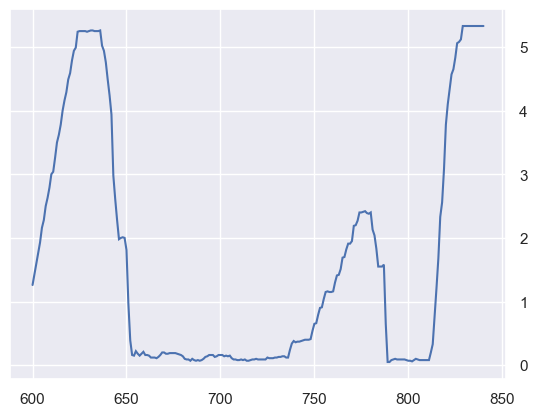

In [13]:
plt.plot(df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"])

In [14]:
df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"].values

array([1.26, 1.43, 1.61, 1.76, 1.93, 2.16, 2.28, 2.5 , 2.63, 2.79, 3.  ,
       3.04, 3.26, 3.5 , 3.62, 3.78, 4.  , 4.16, 4.29, 4.49, 4.59, 4.79,
       4.94, 4.99, 5.24, 5.25, 5.25, 5.25, 5.25, 5.24, 5.25, 5.26, 5.26,
       5.25, 5.25, 5.25, 5.26, 5.02, 4.94, 4.76, 4.49, 4.24, 3.94, 2.98,
       2.61, 2.28, 1.98, 2.  , 2.01, 2.  , 1.81, 0.97, 0.39, 0.16, 0.15,
       0.22, 0.18, 0.15, 0.18, 0.21, 0.16, 0.16, 0.15, 0.12, 0.12, 0.12,
       0.11, 0.13, 0.16, 0.2 , 0.2 , 0.18, 0.18, 0.19, 0.19, 0.19, 0.19,
       0.18, 0.17, 0.16, 0.14, 0.1 , 0.09, 0.09, 0.07, 0.1 , 0.08, 0.07,
       0.08, 0.07, 0.08, 0.1 , 0.13, 0.14, 0.16, 0.16, 0.16, 0.13, 0.14,
       0.16, 0.16, 0.16, 0.14, 0.15, 0.14, 0.15, 0.11, 0.09, 0.09, 0.08,
       0.08, 0.09, 0.08, 0.09, 0.07, 0.07, 0.08, 0.09, 0.09, 0.1 , 0.09,
       0.09, 0.09, 0.09, 0.09, 0.12, 0.11, 0.11, 0.11, 0.12, 0.12, 0.13,
       0.13, 0.14, 0.14, 0.12, 0.12, 0.24, 0.34, 0.38, 0.36, 0.37, 0.37,
       0.38, 0.39, 0.4 , 0.4 , 0.4 , 0.41, 0.54, 0.

In [15]:
# add funds rate to df
df["FEDFUNDS"] = df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"].values
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,FEDFUNDS
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,1.26
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,1.43
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,1.61
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,1.76
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,1.93
...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,5.33
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,5.33
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,5.33
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,5.33


In [16]:
# check if nan into FEDFUNDS
assert df[df["FEDFUNDS"].isna()].shape[0] == 0

In [17]:
# add do Df the indice SPX from yahoo finance ? 
# add the indice SPX from yahoo finance
df_spx = yf.Ticker("^GSPC").history(
    start="2003-07-01", end="2024-08-01", interval="1mo")



In [18]:
df_spx

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-07-01 00:00:00-04:00,974.500000,1015.409973,962.099976,990.309998,31553200000,0.0,0.0
2003-08-01 00:00:00-04:00,990.309998,1011.010010,960.840027,1008.010010,24881470000,0.0,0.0
2003-09-01 00:00:00-04:00,1008.010010,1040.290039,990.359985,995.969971,29940110000,0.0,0.0
2003-10-01 00:00:00-04:00,995.969971,1053.790039,995.969971,1050.709961,32298500000,0.0,0.0
2003-11-01 00:00:00-05:00,1050.709961,1063.650024,1031.199951,1058.199951,24463220000,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-01 00:00:00-05:00,5098.509766,5264.850098,5056.819824,5254.350098,86299510000,0.0,0.0
2024-04-01 00:00:00-04:00,5257.970215,5263.950195,4953.560059,5035.689941,81747170000,0.0,0.0
2024-05-01 00:00:00-04:00,5029.029785,5341.879883,5011.049805,5277.509766,86849720000,0.0,0.0


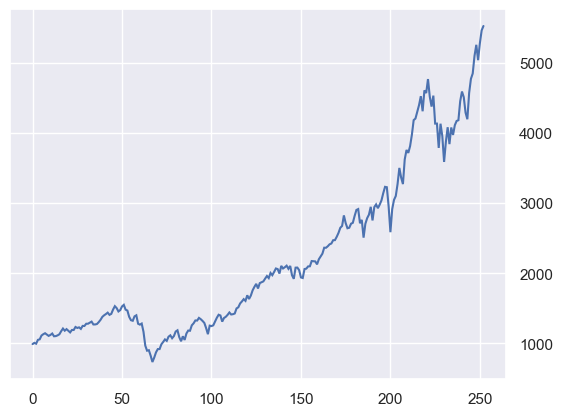

In [19]:
plt.plot(df_spx["Close"].values)

In [20]:
# calculate yoy ratio of SPX from 2004 to 2024 : 
# ratio between year y - 1 and year y 
# => ratio  = (SPX(y) -  SPX(y-1)/ SPX(y-1) for each month
arr_spx_diff = (df_spx["Close"].values[12:]-df_spx["Close"].values[:-12]) / df_spx["Close"].values[:-12]

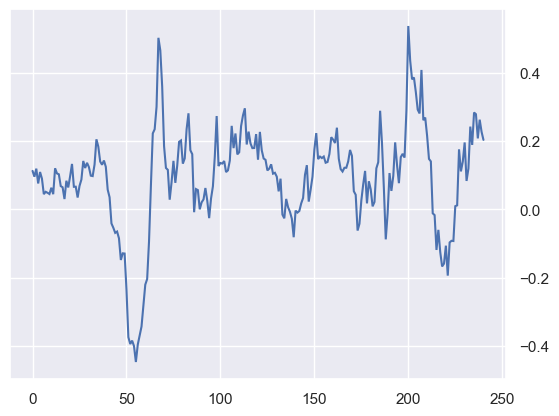

In [21]:
plt.plot(arr_spx_diff)

In [22]:
# add arr_spx_diff to df
df["SPX_diff"] = arr_spx_diff
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,FEDFUNDS,SPX_diff
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,1.26,0.112500
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,1.43,0.095465
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,1.61,0.119090
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,1.76,0.075654
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,1.93,0.109261
...,...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,5.33,0.278645
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,5.33,0.207750
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,5.33,0.262613
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,5.33,0.226969


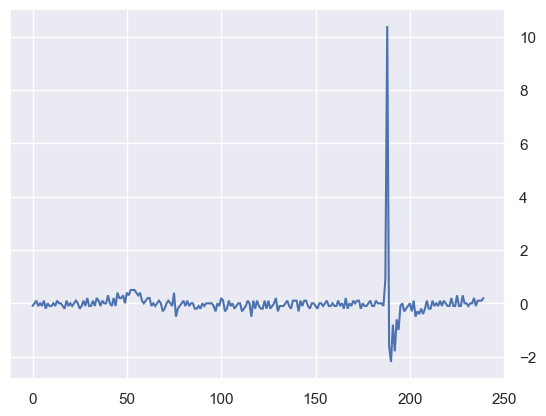

In [23]:
plt.plot(np.diff(df["Total"]))

In [24]:
# calculate next month diff in unemployment rate 
df["Total_diff"] = np.diff(df["Total"], append=np.nan)
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,FEDFUNDS,SPX_diff,Total_diff
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,1.26,0.112500,-0.1
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,1.43,0.095465,0.0
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,1.61,0.119090,0.1
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,1.76,0.075654,-0.1
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,1.93,0.109261,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,5.33,0.278645,0.1
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,5.33,0.207750,0.1
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,5.33,0.262613,0.1
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,5.33,0.226969,0.2


In [25]:
ur_lower = df["Total_diff"] < 0
ur_higher = df["Total_diff"] > 0
ur_stable = df["Total_diff"] == 0
# add ur to df
df["ur_lower"] = ur_lower
df["ur_higher"] = ur_higher
df["ur_stable"] = ur_stable
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,1.26,0.112500,-0.1,True,False,False
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,1.43,0.095465,0.0,False,False,True
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,1.61,0.119090,0.1,False,True,False
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,1.76,0.075654,-0.1,True,False,False
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,1.93,0.109261,0.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,5.33,0.278645,0.1,False,True,False
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,5.33,0.207750,0.1,False,True,False
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,5.33,0.262613,0.1,False,True,False
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,5.33,0.226969,0.2,False,True,False


In [26]:
# function to convert from each str input (i.e: "July 2003") to just the number of the month (i.e: 7) 
def clean_month(str_month):
    return str_month[0:3] + " " + str_month[-4:]
#clean_month("July 2003")
df["Month"] = df["Month"].apply(clean_month)

In [27]:
# convert df["Month"] into a number of the month
df["date"] = pd.to_datetime(df["Month"], format="%b %Y")

In [28]:
df["num_month"] = df["date"].dt.month

In [29]:
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,date,num_month
0,Jul 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,1.26,0.112500,-0.1,True,False,False,2004-07-01,7
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,1.43,0.095465,0.0,False,False,True,2004-08-01,8
2,Sep 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,1.61,0.119090,0.1,False,True,False,2004-09-01,9
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,1.76,0.075654,-0.1,True,False,False,2004-10-01,10
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,1.93,0.109261,0.0,False,False,True,2004-11-01,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,5.33,0.278645,0.1,False,True,False,2024-03-01,3
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,5.33,0.207750,0.1,False,True,False,2024-04-01,4
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,5.33,0.262613,0.1,False,True,False,2024-05-01,5
239,Jun 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,5.33,0.226969,0.2,False,True,False,2024-06-01,6


In [30]:
# add last 3 month data about unemployment rate, inflation , fedfunds, SPX to df 
# as new columns (i.e: "Total-1", "Total-2", "Total-3")

df["Total-1"] = df["Total"].shift(1)
df["Total-2"] = df["Total"].shift(2)
df["Total-3"] = df["Total"].shift(3)

df["Inflation-1"] = df["Inflation"].shift(1)
df["Inflation-2"] = df["Inflation"].shift(2)
df["Inflation-3"] = df["Inflation"].shift(3)

df["fedfunds-1"] = df["FEDFUNDS"].shift(1)
df["fedfunds-2"] = df["FEDFUNDS"].shift(2)
df["fedfunds-3"] = df["FEDFUNDS"].shift(3)

df["spx-1"] = df["SPX_diff"].shift(1)
df["spx-2"] = df["SPX_diff"].shift(2)
df["spx-3"] = df["SPX_diff"].shift(3)

# same for "Men, 20 years and over"
df["Men-1"] = df["Men, 20 years and over"].shift(1)
df["Men-2"] = df["Men, 20 years and over"].shift(2)
df["Men-3"] = df["Men, 20 years and over"].shift(3)

#same for "Women, 20 years and over"
df["Women-1"] = df["Women, 20 years and over"].shift(1)
df["Women-2"] = df["Women, 20 years and over"].shift(2)
df["Women-3"] = df["Women, 20 years and over"].shift(3)

# same for "16 to 19 years old"	
df["16-1"] = df["16 to 19 years old"].shift(1)
df["16-2"] = df["16 to 19 years old"].shift(2)
df["16-3"] = df["16 to 19 years old"].shift(3)

# same for 	"White"	
df["White-1"] = df["White"].shift(1)
df["White-2"] = df["White"].shift(2)
df["White-3"] = df["White"].shift(3)

# same for Black
df["Black-1"] = df["Black or African American"].shift(1)
df["Black-2"] = df["Black or African American"].shift(2)
df["Black-3"] = df["Black or African American"].shift(3)

# same for Asian
df["Asian-1"] = df["Asian"].shift(1)
df["Asian-2"] = df["Asian"].shift(2)
df["Asian-3"] = df["Asian"].shift(3)

# same for Hispanic or Latino
df["Hispanic-1"] = df["Hispanic or Latino"].shift(1)
df["Hispanic-2"] = df["Hispanic or Latino"].shift(2)
df["Hispanic-3"] = df["Hispanic or Latino"].shift(3)

In [31]:
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,...,White-3,Black-1,Black-2,Black-3,Asian-1,Asian-2,Asian-3,Hispanic-1,Hispanic-2,Hispanic-3
0,Jul 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,...,NaN,11.0,NaN,NaN,3.9,NaN,NaN,6.8,NaN,NaN
2,Sep 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,...,NaN,10.5,11.0,NaN,3.7,3.9,NaN,6.8,6.8,NaN
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,...,4.7,10.3,10.5,11.0,4.5,3.7,3.9,6.8,6.8,6.8
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,...,4.7,10.8,10.3,10.5,4.9,4.5,3.7,6.8,6.8,6.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,...,3.5,5.6,5.3,5.2,3.4,2.9,3.1,5.0,5.0,5.0
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,...,3.4,6.4,5.6,5.3,2.5,3.4,2.9,4.5,5.0,5.0
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,...,3.4,5.6,6.4,5.6,2.8,2.5,3.4,4.8,4.5,5.0
239,Jun 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,...,3.4,6.1,5.6,6.4,3.1,2.8,2.5,5.0,4.8,4.5


In [32]:
df.columns

Index(['Month', 'Total', 'Men, 20 years and over', 'Women, 20 years and over',
       '16 to 19 years old', 'White', 'Black or African American', 'Asian',
       'Hispanic or Latino', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'Total_diff',
       'ur_lower', 'ur_higher', 'ur_stable', 'date', 'num_month', 'Total-1',
       'Total-2', 'Total-3', 'Inflation-1', 'Inflation-2', 'Inflation-3',
       'fedfunds-1', 'fedfunds-2', 'fedfunds-3', 'spx-1', 'spx-2', 'spx-3',
       'Men-1', 'Men-2', 'Men-3', 'Women-1', 'Women-2', 'Women-3', '16-1',
       '16-2', '16-3', 'White-1', 'White-2', 'White-3', 'Black-1', 'Black-2',
       'Black-3', 'Asian-1', 'Asian-2', 'Asian-3', 'Hispanic-1', 'Hispanic-2',
       'Hispanic-3'],
      dtype='object')

In [33]:
list_feat = ['Total', 'Men, 20 years and over', 'Women, 20 years and over',
       '16 to 19 years old', 'White', 'Black or African American', 'Asian',
       'Hispanic or Latino', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'num_month', 'Total-1',
       'Total-2', 'Total-3', 'Inflation-1', 'Inflation-2', 'Inflation-3',
       'fedfunds-1', 'fedfunds-2', 'fedfunds-3', 'spx-1', 'spx-2', 'spx-3',
       'Men-1', 'Men-2', 'Men-3', 'Women-1', 'Women-2', 'Women-3', '16-1',
       '16-2', '16-3', 'White-1', 'White-2', 'White-3', 'Black-1', 'Black-2',
       'Black-3', 'Asian-1', 'Asian-2', 'Asian-3', 'Hispanic-1', 'Hispanic-2',
       'Hispanic-3']

df_x = df.dropna().filter(list_feat)
df_x

,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,FEDFUNDS,...,White-3,Black-1,Black-2,Black-3,Asian-1,Asian-2,Asian-3,Hispanic-1,Hispanic-2,Hispanic-3
3,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,1.76,...,4.7,10.3,10.5,11.0,4.5,3.7,3.9,6.8,6.8,6.8
4,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,1.93,...,4.7,10.8,10.3,10.5,4.9,4.5,3.7,6.8,6.8,6.8
5,5.4,4.8,4.6,17.6,4.5,10.7,4.2,6.6,3.3,2.16,...,4.6,10.7,10.8,10.3,4.1,4.9,4.5,6.7,6.8,6.8
6,5.3,4.7,4.7,16.2,4.5,10.6,4.1,6.0,3.0,2.28,...,4.6,10.7,10.7,10.8,4.2,4.1,4.9,6.6,6.7,6.8
7,5.4,4.8,4.7,17.5,4.6,10.9,4.3,6.3,3.0,2.50,...,4.6,10.6,10.7,10.7,4.1,4.2,4.1,6.0,6.6,6.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,3.9,3.5,3.5,12.5,3.4,5.6,3.4,5.0,3.2,5.33,...,3.3,5.3,5.2,5.8,2.9,3.1,3.5,5.0,5.0,4.6
236,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,5.33,...,3.5,5.6,5.3,5.2,3.4,2.9,3.1,5.0,5.0,5.0
237,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,5.33,...,3.4,6.4,5.6,5.3,2.5,3.4,2.9,4.5,5.0,5.0
238,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,5.33,...,3.4,5.6,6.4,5.6,2.8,2.5,3.4,4.8,4.5,5.0


In [34]:
df_y = df.dropna().filter(['Total_diff',
       'ur_lower', 'ur_higher', 'ur_stable'])
df_y

,Total_diff,ur_lower,ur_higher,ur_stable
3,-0.1,True,False,False
4,0.0,False,False,True
5,-0.1,True,False,False
6,0.1,False,True,False
7,-0.2,True,False,False
...,...,...,...,...
235,-0.1,True,False,False
236,0.1,False,True,False
237,0.1,False,True,False
238,0.1,False,True,False


In [35]:
data = df_x.values
data

array([[5.5, 4.9, 4.7, ..., 6.8, 6.8, 6.8],
       [5.4, 4.9, 4.7, ..., 6.8, 6.8, 6.8],
       [5.4, 4.8, 4.6, ..., 6.7, 6.8, 6.8],
       ...,
       [3.9, 3.6, 3.5, ..., 4.5, 5. , 5. ],
       [4. , 3.8, 3.4, ..., 4.8, 4.5, 5. ],
       [4.1, 3.8, 3.7, ..., 5. , 4.8, 4.5]])

## Target

In [36]:
target = df_y["ur_lower"].values
target

array([ True, False,  True, False,  True, False,  True,  True, False,
        True, False, False, False,  True,  True, False,  True, False,
        True, False, False, False,  True,  True, False,  True, False,
        True,  True, False,  True, False, False,  True, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False,  True,  True, False, False, False,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
       False, False,  True,  True,  True,  True, False,  True, False,
       False, False, False,  True,  True, False,  True, False, False,
        True,  True, False,  True, False,  True,  True, False, False,
        True,  True,  True, False, False,  True, False,  True, False,
        True,  True,  True, False,  True, False,  True,  True, False,
       False,  True,

## SPlit Train / Test

In [37]:
data.shape

(237, 45)

In [38]:
ratio_test = 0.13
nb_test = int(data.shape[0] * (1 - ratio_test))
print("nb_test : ", nb_test)
#from sklearn.model_selection import train_test_split
#xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8)
xtrain = data[:nb_test, :]
xtest = data[nb_test:, :]
ytrain = target[:nb_test]
ytest = target[nb_test:]

nb_test :  206


In [39]:
ytrain.shape

(206,)

In [40]:
ytest.shape

(31,)

In [41]:
df_train = df.iloc[:nb_test].copy()
df_train
df_test = df.iloc[nb_test:].copy()
df_test

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,...,White-3,Black-1,Black-2,Black-3,Asian-1,Asian-2,Asian-3,Hispanic-1,Hispanic-2,Hispanic-3
206,Sep 2021,4.7,4.7,4.3,11.3,4.2,7.7,4.2,6.2,5.4,...,5.2,8.6,8.1,9.1,4.5,5.3,5.6,6.1,6.5,7.3
207,Oct 2021,4.5,4.2,4.2,11.3,3.9,7.6,4.2,5.7,6.2,...,4.8,7.7,8.6,8.1,4.2,4.5,5.3,6.2,6.1,6.5
208,Nov 2021,4.1,3.9,3.9,10.9,3.7,6.4,3.8,5.0,6.8,...,4.5,7.6,7.7,8.6,4.2,4.2,4.5,5.7,6.2,6.1
209,Dec 2021,3.9,3.6,3.6,11.0,3.3,6.9,3.8,4.6,7.0,...,4.2,6.4,7.6,7.7,3.8,4.2,4.2,5.0,5.7,6.2
210,Jan 2022,4.0,3.8,3.6,11.2,3.4,7.0,3.6,4.7,7.5,...,3.9,6.9,6.4,7.6,3.8,3.8,4.2,4.6,5.0,5.7
211,Feb 2022,3.8,3.5,3.7,10.2,3.3,6.6,2.9,4.3,7.9,...,3.7,7.0,6.9,6.4,3.6,3.8,3.8,4.7,4.6,5.0
212,Mar 2022,3.6,3.4,3.4,10.3,3.2,6.4,2.7,4.2,8.5,...,3.3,6.6,7.0,6.9,2.9,3.6,3.8,4.3,4.7,4.6
213,Apr 2022,3.7,3.5,3.3,10.6,3.3,6.1,3.0,4.2,8.3,...,3.4,6.4,6.6,7.0,2.7,2.9,3.6,4.2,4.3,4.7
214,May 2022,3.6,3.4,3.4,10.5,3.2,6.2,2.4,4.4,8.6,...,3.3,6.1,6.4,6.6,3.0,2.7,2.9,4.2,4.2,4.3
215,Jun 2022,3.6,3.4,3.3,10.9,3.3,5.8,2.9,4.3,9.1,...,3.2,6.2,6.1,6.4,2.4,3.0,2.7,4.4,4.2,4.2


### Check features repart

In [73]:
df_train["TRAIN"] = 1
df_test["TRAIN"] = 0
df = pd.concat([df_train, df_test], axis=0)
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,...,Black-1,Black-2,Black-3,Asian-1,Asian-2,Asian-3,Hispanic-1,Hispanic-2,Hispanic-3,TRAIN
0,Jul 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,...,11.0,NaN,NaN,3.9,NaN,NaN,6.8,NaN,NaN,1
2,Sep 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,...,10.5,11.0,NaN,3.7,3.9,NaN,6.8,6.8,NaN,1
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,...,10.3,10.5,11.0,4.5,3.7,3.9,6.8,6.8,6.8,1
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,...,10.8,10.3,10.5,4.9,4.5,3.7,6.8,6.8,6.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,...,5.6,5.3,5.2,3.4,2.9,3.1,5.0,5.0,5.0,0
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,...,6.4,5.6,5.3,2.5,3.4,2.9,4.5,5.0,5.0,0
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,...,5.6,6.4,5.6,2.8,2.5,3.4,4.8,4.5,5.0,0
239,Jun 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,...,6.1,5.6,6.4,3.1,2.8,2.5,5.0,4.8,4.5,0


#### Check Out of range
check if Test out of Train range for each features

In [88]:
df_min = df.filter(list_feat).groupby(df["TRAIN"]).min().transpose()
df_min["out_min"] = df_min[0] < df_min[1]
df_min

TRAIN,0,1,out_min
Total,3.400000,3.500000,True
"Men, 20 years and over",3.100000,3.200000,True
"Women, 20 years and over",3.100000,3.100000,False
16 to 19 years old,9.300000,9.700000,True
White,3.000000,3.000000,False
Black or African American,4.800000,5.300000,True
Asian,2.300000,2.000000,False
Hispanic or Latino,3.900000,3.900000,False
Inflation,2.900000,-2.100000,False
FEDFUNDS,0.080000,0.050000,False


In [102]:
df[df["TRAIN"] == 1]["Total"].min()

3.5

In [103]:
df[df["TRAIN"] == 0]["Total"].min()

3.4

In [104]:
df["train"] = df["TRAIN"].apply(lambda x: "TRAIN" if x == 1 else "TEST")

<Axes: ylabel='Total'>

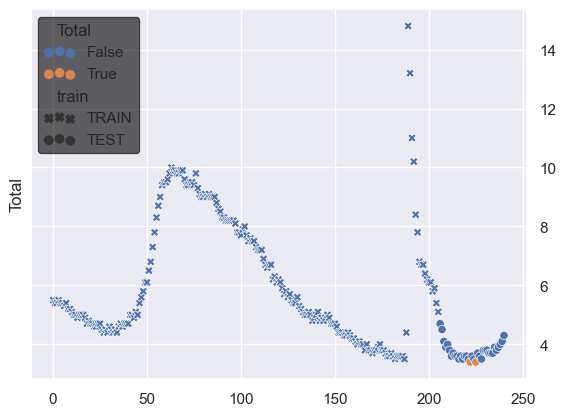

In [110]:
markers = {"TRAIN": "X", "TEST": "o"}
sns.scatterplot(df.index.values, df["Total"], hue=df["Total"] <= 3.400000, style=df["train"], markers=markers)

### Check repart target

In [42]:
print("repart ur_higher : ")
print("on TRAIN :\n", df_train["ur_higher"].value_counts() / df_train.shape[0])
print("on TEST :\n", df_test["ur_higher"].value_counts() / df_test.shape[0])
print("\nrepart ur_stable : ")
print("on TRAIN :\n", df_train["ur_stable"].value_counts() / df_train.shape[0])
print("on TEST :\n", df_test["ur_stable"].value_counts() / df_test.shape[0])
print("\nrepart ur_lower : ")
print("on TRAIN :\n", df_train["ur_lower"].value_counts() / df_train.shape[0])
print("on TEST :\n", df_test["ur_lower"].value_counts() / df_test.shape[0])

repart ur_higher : 
on TRAIN :
 False    0.703883
True     0.296117
Name: ur_higher, dtype: float64
on TEST :
 False    0.657143
True     0.342857
Name: ur_higher, dtype: float64

repart ur_stable : 
on TRAIN :
 False    0.757282
True     0.242718
Name: ur_stable, dtype: float64
on TEST :
 False    0.828571
True     0.171429
Name: ur_stable, dtype: float64

repart ur_lower : 
on TRAIN :
 False    0.538835
True     0.461165
Name: ur_lower, dtype: float64
on TEST :
 False    0.542857
True     0.457143
Name: ur_lower, dtype: float64


## Scale

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(xtrain)
X_test = scaler.transform(xtest)

# for last pred : (to predict next month value)
x_for_pred = df.filter(list_feat).iloc[-1].values.reshape(1, -1)
X_for_pred = scaler.transform(x_for_pred)
X_for_pred

array([[-0.89362262, -0.84172603, -0.89560813, -1.21666527, -0.86113879,
        -1.34699139, -0.54441354, -0.83348891,  0.51254654,  2.42676861,
         0.71971087,  0.13336476, -0.99376755, -1.0447858 , -1.09540774,
         0.61049083,  0.84981377,  0.9416392 ,  2.42530905,  2.42458342,
         2.42441407,  0.88026961,  1.13482767,  0.78111389, -0.93685513,
        -0.93958395, -1.03203782, -0.95122051, -1.11157369, -1.0607441 ,
        -1.29214158, -1.26187656, -1.4025988 , -1.01797863, -1.02120025,
        -1.02312293, -1.35860751, -1.42879911, -1.59405373, -0.35621541,
        -0.82991474, -0.97147704, -0.97637578, -0.94454162, -1.01519248]])

In [44]:
#scaler_y = StandardScaler()

#Y = scaler_y.fit_transform(ytrain.reshape(-1, 1))
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

In [45]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))

TRAIN score : 0.5825242718446602
TEST score : 0.5483870967741935


In [46]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))

TRAIN score : 0.5728155339805825
TEST score : 0.5806451612903226


In [47]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))

TRAIN score : 1.0
TEST score : 0.6129032258064516


In [48]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))

TRAIN score : 0.6456310679611651
TEST score : 0.5483870967741935


In [49]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(random_state=0)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))

TRAIN score : 0.616504854368932
TEST score : 0.45161290322580644


In [50]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))

TRAIN score : 1.0
TEST score : 0.5806451612903226


In [51]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, 
                    max_iter=10000,
                    early_stopping=True,
                    n_iter_no_change=1000)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))


TRAIN score : 0.6601941747572816
TEST score : 0.6129032258064516


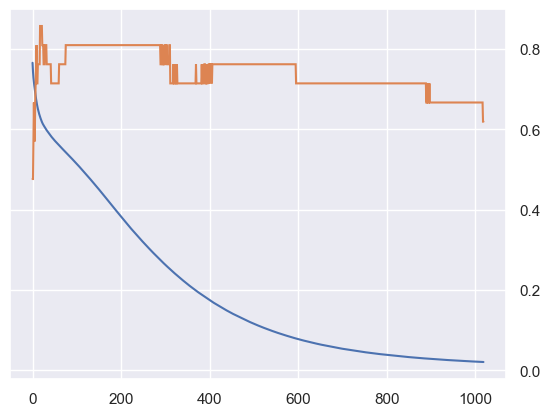

In [52]:
plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)

In [53]:
X.shape

(206, 45)

In [54]:
X_test.shape

(31, 45)

In [55]:
clf.predict(X_for_pred)

array([False])

In [56]:
clf.classes_

array([False,  True])

In [57]:
clf.predict_proba(X_for_pred)

array([[0.5362184, 0.4637816]])

### KNN

In [58]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)

# target lower
print("TARGET : LOWER ")
target = df_y["ur_lower"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))

# target higher
print("TARGET : HIGHER")
target = df_y["ur_higher"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))

# target stable
print("\nTARGET : STABLE")
target = df_y["ur_stable"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))

TARGET : LOWER 
TRAIN score : 0.7378640776699029
TEST score : 0.7096774193548387
Next month :  [False]
classes :  [False  True]
classes prob :  [[0.66666667 0.33333333]]
TARGET : HIGHER
TRAIN score : 0.7864077669902912
TEST score : 0.7096774193548387
Next month :  [ True]
classes :  [False  True]
classes prob :  [[0.33333333 0.66666667]]

TARGET : STABLE
TRAIN score : 0.8300970873786407
TEST score : 0.8709677419354839
Next month :  [False]
classes :  [False  True]
classes prob :  [[1. 0.]]


### MCP

In [59]:
from sklearn.neural_network  import MLPClassifier
list_pred = []
list_prob = []

TARGET : LOWER 
TRAIN score : 0.6601941747572816
TEST score : 0.6129032258064516
Next month :  [False]
classes :  [False  True]
classes prob :  [[0.5362184 0.4637816]]
nb_test:  17


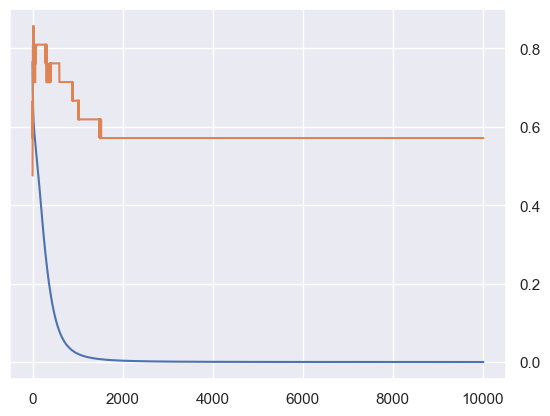

In [67]:
# target lower
print("TARGET : LOWER ")
target = df_y["ur_lower"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

clf = MLPClassifier(random_state=0,
                    hidden_layer_sizes=(32,16),
                    max_iter=50000,
                    early_stopping=True,
                    n_iter_no_change=10000)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))
nb_best = np.argmax(clf.validation_scores_ == clf.best_validation_score_)
print("nb_test: ", nb_best)
plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)

In [61]:
pred = clf.predict(X_for_pred)[0]
arr_prob = clf.predict_proba(X_for_pred)
if pred: 
    prob = arr_prob[0][1]
else:
    prob = arr_prob[0][0]

list_pred.append(pred)
list_prob.append(prob)
print(list_pred, list_prob)

[False] [0.9999998324057179]


TARGET : STABLE 
TRAIN score : 0.7912621359223301
TEST score : 0.8064516129032258
Next month :  [False]
classes :  [False  True]
classes prob :  [[0.71473392 0.28526608]]
nb_test:  116


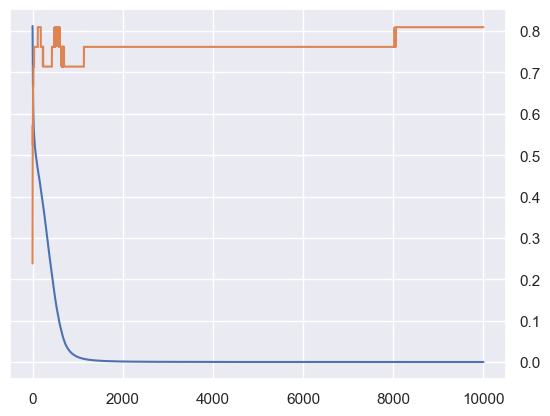

In [62]:
# target stable
print("TARGET : STABLE ")
target = df_y["ur_stable"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

clf = MLPClassifier(random_state=2,
                    hidden_layer_sizes=(32,16),
                    max_iter=10000,
                    early_stopping=True,
                    n_iter_no_change=10000)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))
nb_best = np.argmax(clf.validation_scores_ == clf.best_validation_score_)
print("nb_test: ", nb_best)
plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)

In [63]:
pred = clf.predict(X_for_pred)[0]
arr_prob = clf.predict_proba(X_for_pred)
if pred: 
    prob = arr_prob[0][1]
else:
    prob = arr_prob[0][0]

list_pred.append(pred)
list_prob.append(prob)
print(list_pred, list_prob)

[False, False] [0.9999998324057179, 0.7147339214991408]


TARGET : HIGHER 
TRAIN score : 0.7087378640776699
TEST score : 0.6129032258064516
Next month :  [False]
classes :  [False  True]
classes prob :  [[0.82078501 0.17921499]]
nb_test:  0


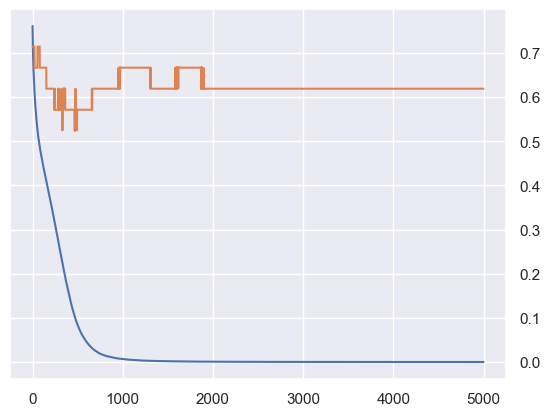

In [65]:
# target Higher
print("TARGET : HIGHER ")
target = df_y["ur_higher"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

clf = MLPClassifier(random_state=0,
                    hidden_layer_sizes=(32,16),
                    max_iter=5000,
                    early_stopping=True,
                    n_iter_no_change=5000)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))
nb_best = np.argmax( clf.validation_scores_ == clf.best_validation_score_)
print("nb_test: ", nb_best)
plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)


In [66]:
pred = clf.predict(X_for_pred)[0]
arr_prob = clf.predict_proba(X_for_pred)
if pred: 
    prob = arr_prob[0][1]
else:
    prob = arr_prob[0][0]

list_pred.append(pred)
list_prob.append(prob)
print(list_pred, list_prob)

[False, False, False] [0.9999998324057179, 0.7147339214991408, 0.8207850116880363]
